<a href="https://colab.research.google.com/github/waseem39/LSTM-Forecasting/blob/main/LSTM_Best_For_Population_Dyanmics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

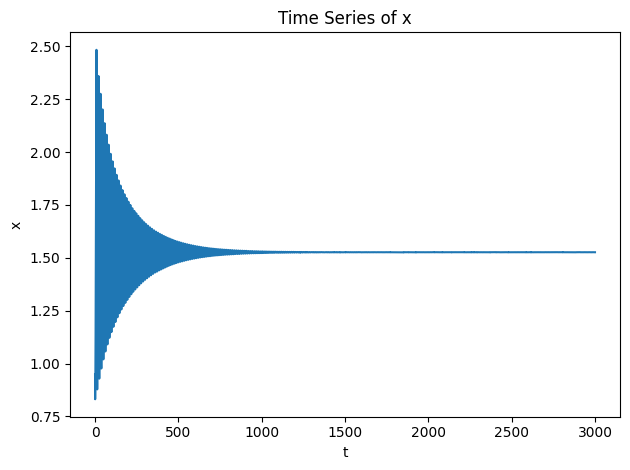

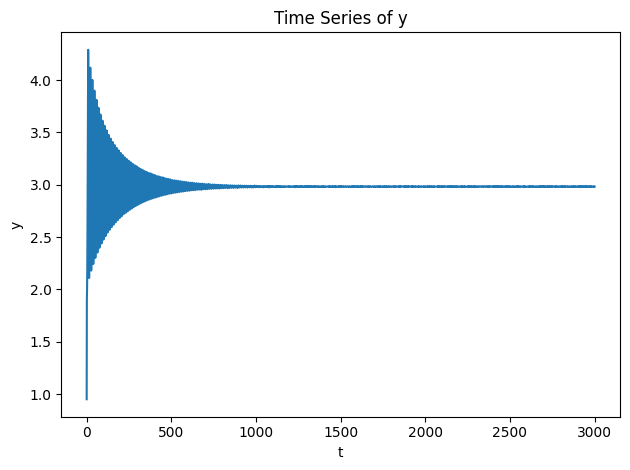

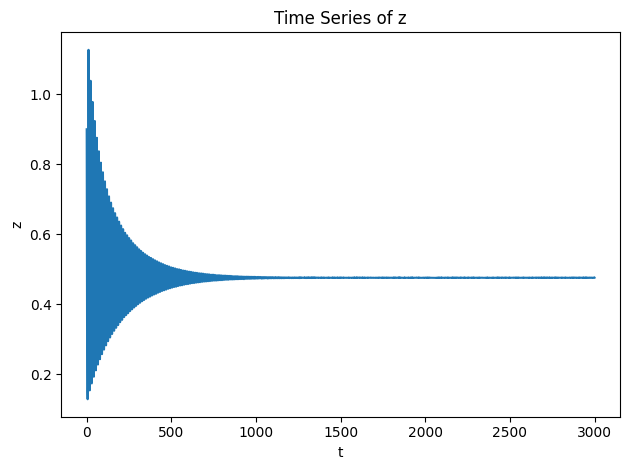

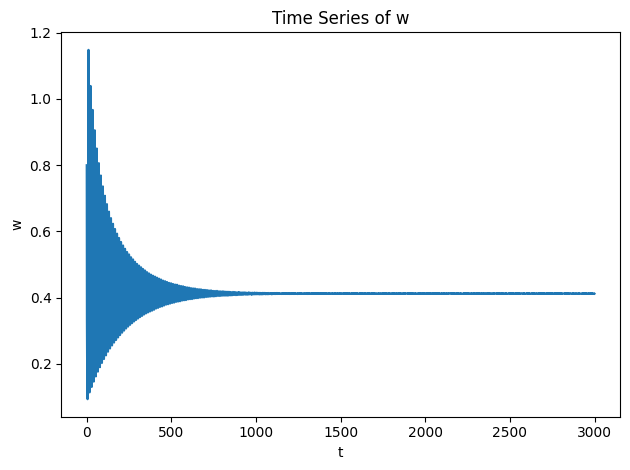

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Parameters
a = 2
b = 0.33
c = .9
d = 0.15
e = 1.07


# Initial conditions
X0 = [0.95, 0.95, 0.9, 0.8]

# Time span
t_start = 0
t_end = 3000
t_eval = np.arange(t_start, t_end + 0.1, 0.1)

def ode_fun(t, X):
    x, y, z, w = X
    dxdt = d * y - b * x * (z + w)
    dydt = a * (x + z) - b * y * (z + w) - (c + d) * y
    dzdt = b * x * (z + w) + d * w - e * z
    dwdt = b * y * (z + w) - (c + e + d) * w
    return [dxdt, dydt, dzdt, dwdt]

# Solve the system of ODEs using RK45
sol = solve_ivp(ode_fun, [t_start, t_end], X0, t_eval=t_eval, method='RK45')

# Extract results within the specified range
t1 = sol.t
x = sol.y[0, :]
y = sol.y[1, :]
z = sol.y[2, :]
w = sol.y[3, :]

# Plot the time series
plt.figure()
plt.plot(t1, x)
plt.xlabel('t')
plt.ylabel('x')
plt.title('Time Series of x')
plt.tight_layout()

plt.figure()
plt.plot(t1, y)
plt.xlabel('t')
plt.ylabel('y')
plt.title('Time Series of y')
plt.tight_layout()

plt.figure()
plt.plot(t1, z)
plt.xlabel('t')
plt.ylabel('z')
plt.title('Time Series of z')
plt.tight_layout()

plt.figure()
plt.plot(t1, w)
plt.xlabel('t')
plt.ylabel('w')
plt.title('Time Series of w')
plt.tight_layout()

plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Select target variable and predictors
target_variable = x
predictors = np.stack([ y, z, w], axis=1)

# Split data into training and testing sets
train_ratio = 0.85
n = len(target_variable)
idx = int(n * train_ratio)
X_train = predictors[:idx, :]
Y_train = target_variable[:idx]
X_test = predictors[idx:, :]
Y_test = target_variable[idx:]

In [ ]:
# Normalize the data
scaler_X = StandardScaler()
scaler_Y = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
Y_train = scaler_Y.fit_transform(Y_train.reshape(-1, 1)).flatten()
X_test = scaler_X.transform(X_test)
Y_test = scaler_Y.transform(Y_test.reshape(-1, 1)).flatten()


In [ ]:
# Reshape input data to be 3D [samples, timesteps, features]
X_train = np.expand_dims(X_train, axis=1)
X_test = np.expand_dims(X_test, axis=1)

In [ ]:
# Define the LSTM network architecture
model = Sequential()
model.add(LSTM(50, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(50, activation='tanh'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Train the network with early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
history = model.fit(X_train, Y_train, epochs=250, batch_size=10, validation_split=0.1, callbacks=[early_stop], verbose=1)


Epoch 1/250
2295/2295 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 0.2205 - val_loss: 0.0016
Epoch 2/250
2295/2295 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0029 - val_loss: 6.0695e-05
Epoch 3/250
2295/2295 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0028 - val_loss: 7.6032e-05
Epoch 4/250
2295/2295 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0020 - val_loss: 9.7364e-05
Epoch 5/250
2295/2295 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0019 - val_loss: 6.6703e-05
Epoch 6/250
2295/2295 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0012 - val_loss: 5.3600e-05
Epoch 7/250
2295/2295 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.0013 - val_loss: 6.3798e-05
Epoch 8/250
2295/2295 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.0021 - val_loss: 5.6627e-05
Epoch 9/250
2295/2295 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0012 - val_loss: 7.0208e-05
Epoch 10/250
2295/2295 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0013 - val_loss: 1.2731e-04
Epoch 11/250
2295/2295 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0

In [ ]:
# Predict in batches
batch_size = 10
num_samples = X_test.shape[0]
num_batches = int(np.ceil(num_samples / batch_size))
Y_pred = []

for batch in range(num_batches):
    start_idx = batch * batch_size
    end_idx = min((batch + 1) * batch_size, num_samples)
    batch_input = X_test[start_idx:end_idx]
    batch_predictions = model.predict(batch_input)
    Y_pred.extend(batch_predictions.flatten())

Y_pred = np.array(Y_pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━

In [ ]:
 #Unnormalize the predictions
Y_pred = scaler_Y.inverse_transform(Y_pred.reshape(-1, 1)).flatten()
Y_test = scaler_Y.inverse_transform(Y_test.reshape(-1, 1)).flatten()


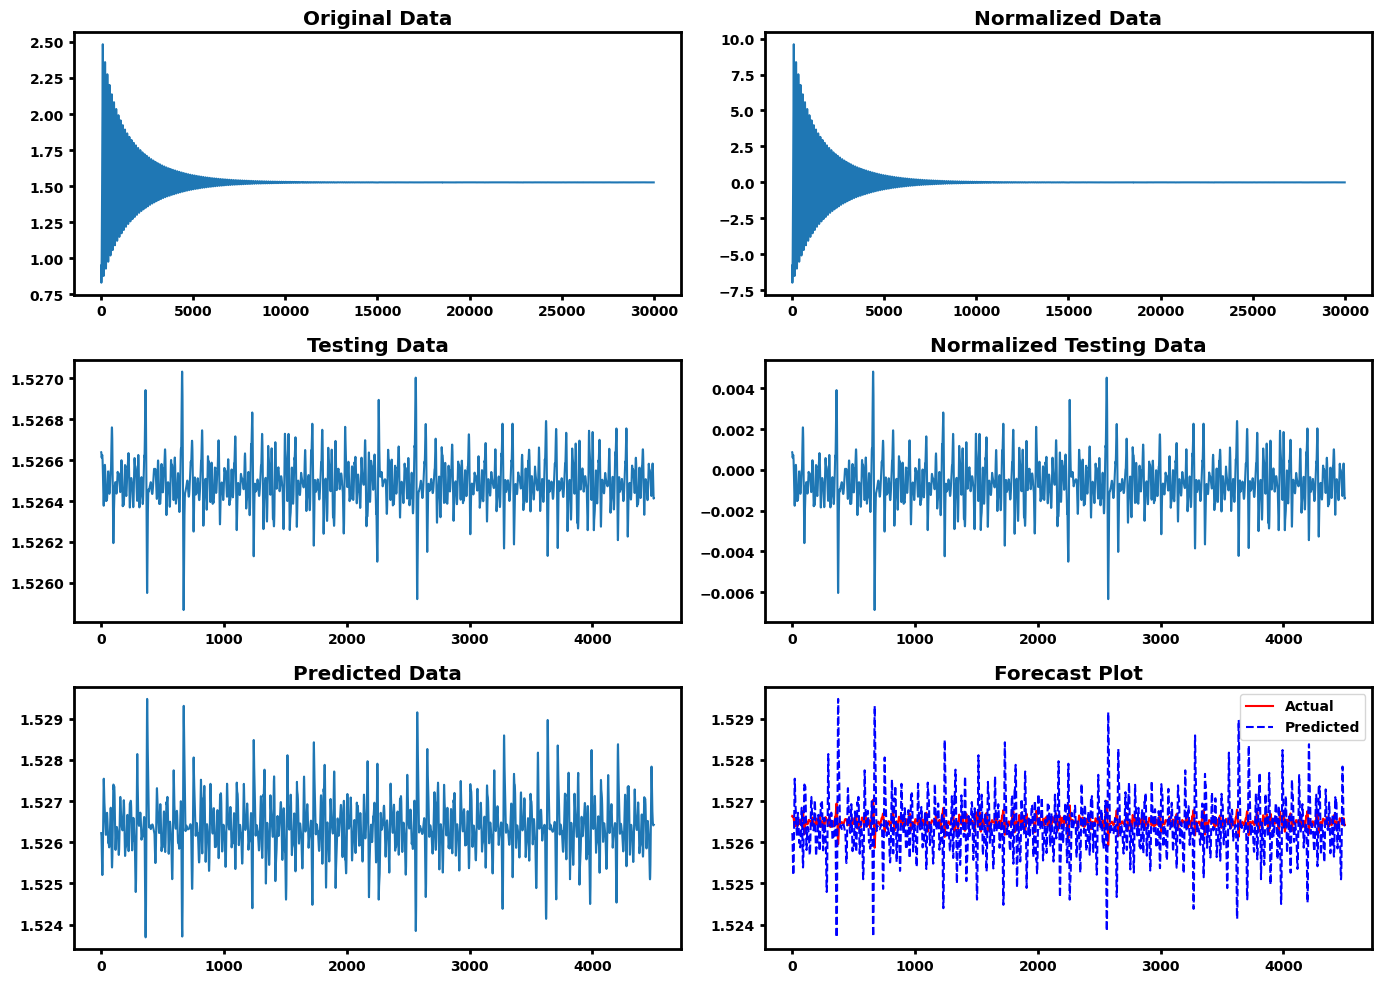

In [ ]:
import matplotlib.pyplot as plt

# Set global font properties (bold, larger font size)
plt.rcParams.update({'font.size': 12, 'font.weight': 'bold'})

# Plot the results
plt.figure(figsize=(14, 10))

def set_bold_axes(ax):
    ax.spines['top'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.tick_params(axis='both', which='major', labelsize=10, width=2)

# Subplot 1
ax1 = plt.subplot(3, 2, 1)
ax1.plot(target_variable)
ax1.set_title('Original Data', fontweight='bold')
set_bold_axes(ax1)

# Subplot 2
ax2 = plt.subplot(3, 2, 2)
ax2.plot(scaler_Y.transform(target_variable.reshape(-1, 1)))
ax2.set_title('Normalized Data', fontweight='bold')
set_bold_axes(ax2)

# Subplot 3
ax3 = plt.subplot(3, 2, 3)
ax3.plot(Y_test)
ax3.set_title('Testing Data', fontweight='bold')
set_bold_axes(ax3)

# Subplot 4
ax4 = plt.subplot(3, 2, 4)
ax4.plot(scaler_Y.transform(Y_test.reshape(-1, 1)))
ax4.set_title('Normalized Testing Data', fontweight='bold')
set_bold_axes(ax4)

# Subplot 5
ax5 = plt.subplot(3, 2, 5)
ax5.plot(Y_pred)
ax5.set_title('Predicted Data', fontweight='bold')
set_bold_axes(ax5)

# Subplot 6
ax6 = plt.subplot(3, 2, 6)
ax6.plot(Y_test, 'r')
ax6.plot(Y_pred, 'b--')
ax6.legend(['Actual', 'Predicted'], fontsize=10)
ax6.set_title('Forecast Plot', fontweight='bold')
set_bold_axes(ax6)

plt.tight_layout()
plt.show()


In [ ]:
# Calculate and print error metrics
mae = np.mean(np.abs(Y_pred - Y_test))  # Mean Absolute Error
mse = np.mean((Y_pred - Y_test) ** 2)   # Mean Squared Error
rmse = np.sqrt(mse)                     # Root Mean Squared Error
mape = np.mean(np.abs((Y_pred - Y_test) / Y_test)) * 100  # Mean Absolute Percentage Error

print(f'Mean Absolute Error: {mae:.4f}')
print(f'Mean Squared Error: {mse:.4f}')
print(f'Root Mean Squared Error: {rmse:.4f}')
print(f'Mean Absolute Percentage Error: {mape:.2f}%')

Mean Absolute Error: 0.0005
Mean Squared Error: 0.0000
Root Mean Squared Error: 0.0007
Mean Absolute Percentage Error: 0.04%


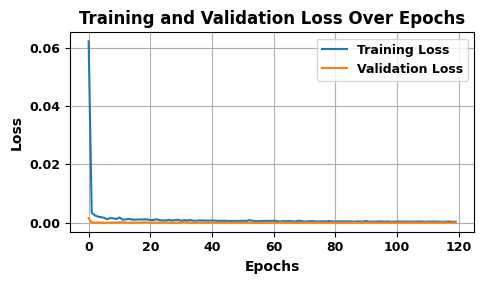

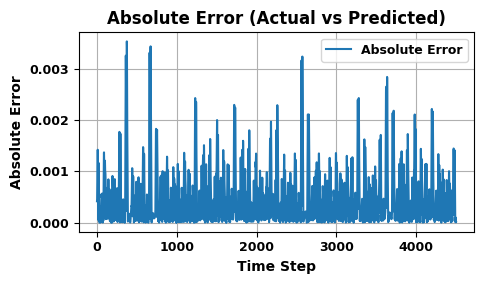

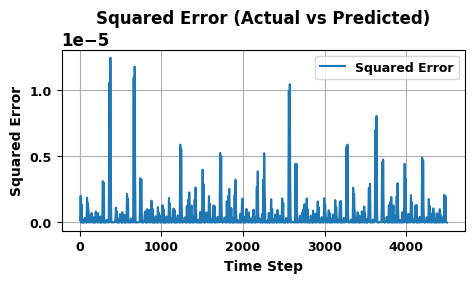

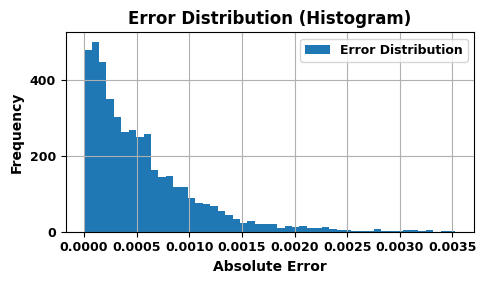

In [ ]:
import matplotlib.pyplot as plt
import numpy as np  # Ensure numpy is imported

# Plot Training and Validation Loss
plt.figure(figsize=(5, 3))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs', fontsize=12, fontweight='bold')
plt.xlabel('Epochs', fontsize=10, fontweight='bold')
plt.ylabel('Loss', fontsize=10, fontweight='bold')
plt.xticks(fontsize=9, fontweight='bold')
plt.yticks(fontsize=9, fontweight='bold')
plt.legend(fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Absolute Error (Actual vs Predicted)
abs_error = np.abs(Y_pred - Y_test)

plt.figure(figsize=(5, 3))
plt.plot(abs_error, label='Absolute Error')
plt.title('Absolute Error (Actual vs Predicted)', fontsize=12, fontweight='bold')
plt.xlabel('Time Step', fontsize=10, fontweight='bold')
plt.ylabel('Absolute Error', fontsize=10, fontweight='bold')
plt.xticks(fontsize=9, fontweight='bold')
plt.yticks(fontsize=9, fontweight='bold')
plt.legend(fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Squared Error (Actual vs Predicted)
squared_error = (Y_pred - Y_test) ** 2

plt.figure(figsize=(5, 3))
plt.plot(squared_error, label='Squared Error')
plt.title('Squared Error (Actual vs Predicted)', fontsize=12, fontweight='bold')
plt.xlabel('Time Step', fontsize=10, fontweight='bold')
plt.ylabel('Squared Error', fontsize=10, fontweight='bold')
plt.xticks(fontsize=9, fontweight='bold')
plt.yticks(fontsize=9, fontweight='bold')
plt.legend(fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Error Distribution (Histogram)
plt.figure(figsize=(5, 3))
plt.hist(abs_error, bins=50, label='Error Distribution')
plt.title('Error Distribution (Histogram)', fontsize=12, fontweight='bold')
plt.xlabel('Absolute Error', fontsize=10, fontweight='bold')
plt.ylabel('Frequency', fontsize=10, fontweight='bold')
plt.xticks(fontsize=9, fontweight='bold')
plt.yticks(fontsize=9, fontweight='bold')
plt.legend(fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.show()



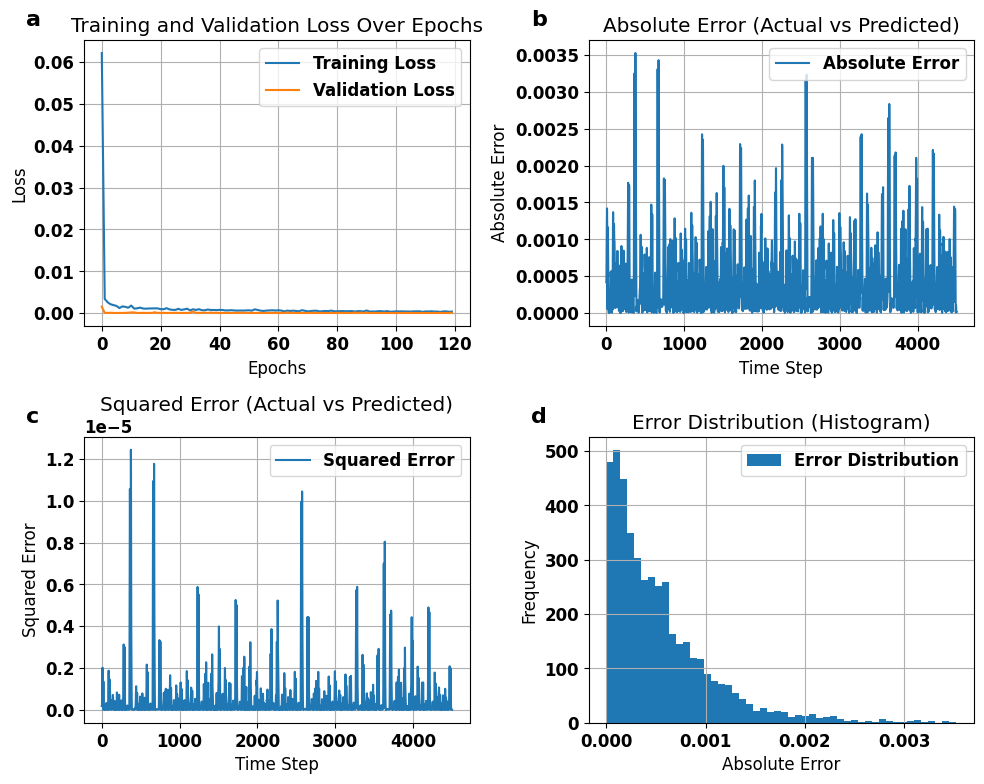

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming history.history['loss'], history.history['val_loss'], Y_pred, and Y_test are defined

# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Panel (a) - Plot Training and Validation Loss
axes[0, 0].plot(history.history['loss'], label='Training Loss')
axes[0, 0].plot(history.history['val_loss'], label='Validation Loss')
axes[0, 0].set_title('Training and Validation Loss Over Epochs')
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)
axes[0, 0].text(-0.15, 1.05, 'a', transform=axes[0, 0].transAxes, fontsize=16, fontweight='bold')

# Panel (b) - Plot Absolute Error (Actual vs Predicted)
abs_error = np.abs(Y_pred - Y_test)
axes[0, 1].plot(abs_error, label='Absolute Error')
axes[0, 1].set_title('Absolute Error (Actual vs Predicted)')
axes[0, 1].set_xlabel('Time Step')
axes[0, 1].set_ylabel('Absolute Error')
axes[0, 1].legend()
axes[0, 1].grid(True)
axes[0, 1].text(-0.15, 1.05, 'b', transform=axes[0, 1].transAxes, fontsize=16, fontweight='bold')

# Panel (c) - Plot Squared Error (Actual vs Predicted)
squared_error = (Y_pred - Y_test) ** 2
axes[1, 0].plot(squared_error, label='Squared Error')
axes[1, 0].set_title('Squared Error (Actual vs Predicted)')
axes[1, 0].set_xlabel('Time Step')
axes[1, 0].set_ylabel('Squared Error')
axes[1, 0].legend()
axes[1, 0].grid(True)
axes[1, 0].text(-0.15, 1.05, 'c', transform=axes[1, 0].transAxes, fontsize=16, fontweight='bold')

# Panel (d) - Plot Error Distribution (Histogram)
axes[1, 1].hist(abs_error, bins=50, label='Error Distribution')
axes[1, 1].set_title('Error Distribution (Histogram)')
axes[1, 1].set_xlabel('Absolute Error')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()
axes[1, 1].grid(True)
axes[1, 1].text(-0.15, 1.05, 'd', transform=axes[1, 1].transAxes, fontsize=16, fontweight='bold')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


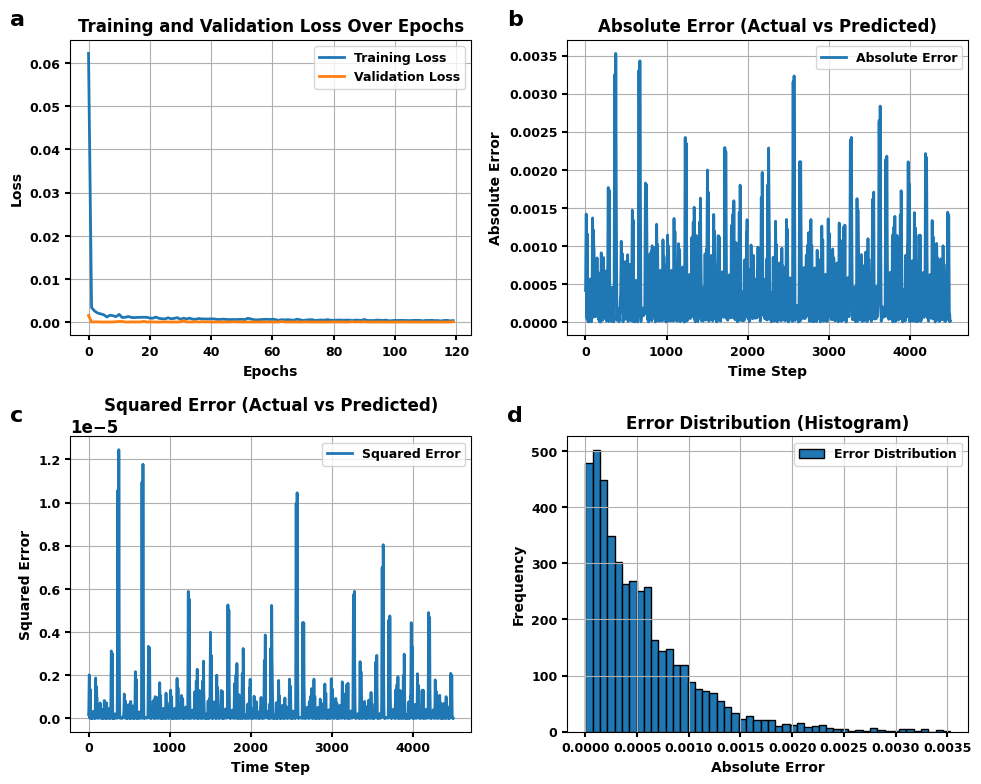

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Define a helper function to bold fonts and ticks
def boldify(ax, title, xlabel, ylabel):
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel(xlabel, fontsize=10, fontweight='bold')
    ax.set_ylabel(ylabel, fontsize=10, fontweight='bold')
    ax.tick_params(axis='both', labelsize=9, width=1.5)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')

# Panel (a) - Training and Validation Loss
axes[0, 0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0, 0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
boldify(axes[0, 0], 'Training and Validation Loss Over Epochs', 'Epochs', 'Loss')
axes[0, 0].legend(fontsize=9)
axes[0, 0].grid(True)
axes[0, 0].text(-0.15, 1.05, 'a', transform=axes[0, 0].transAxes, fontsize=16, fontweight='bold')

# Panel (b) - Absolute Error
abs_error = np.abs(Y_pred - Y_test)
axes[0, 1].plot(abs_error, label='Absolute Error', linewidth=2)
boldify(axes[0, 1], 'Absolute Error (Actual vs Predicted)', 'Time Step', 'Absolute Error')
axes[0, 1].legend(fontsize=9)
axes[0, 1].grid(True)
axes[0, 1].text(-0.15, 1.05, 'b', transform=axes[0, 1].transAxes, fontsize=16, fontweight='bold')

# Panel (c) - Squared Error
squared_error = (Y_pred - Y_test) ** 2
axes[1, 0].plot(squared_error, label='Squared Error', linewidth=2)
boldify(axes[1, 0], 'Squared Error (Actual vs Predicted)', 'Time Step', 'Squared Error')
axes[1, 0].legend(fontsize=9)
axes[1, 0].grid(True)
axes[1, 0].text(-0.15, 1.05, 'c', transform=axes[1, 0].transAxes, fontsize=16, fontweight='bold')

# Panel (d) - Error Histogram
axes[1, 1].hist(abs_error, bins=50, label='Error Distribution', linewidth=1, edgecolor='black')
boldify(axes[1, 1], 'Error Distribution (Histogram)', 'Absolute Error', 'Frequency')
axes[1, 1].legend(fontsize=9)
axes[1, 1].grid(True)
axes[1, 1].text(-0.15, 1.05, 'd', transform=axes[1, 1].transAxes, fontsize=16, fontweight='bold')

# Adjust layout
plt.tight_layout()
plt.show()


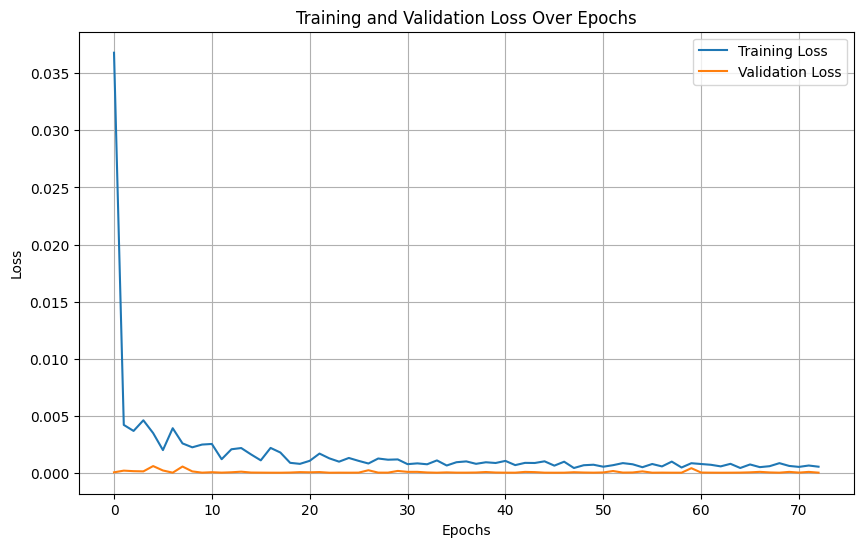

797/797 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step


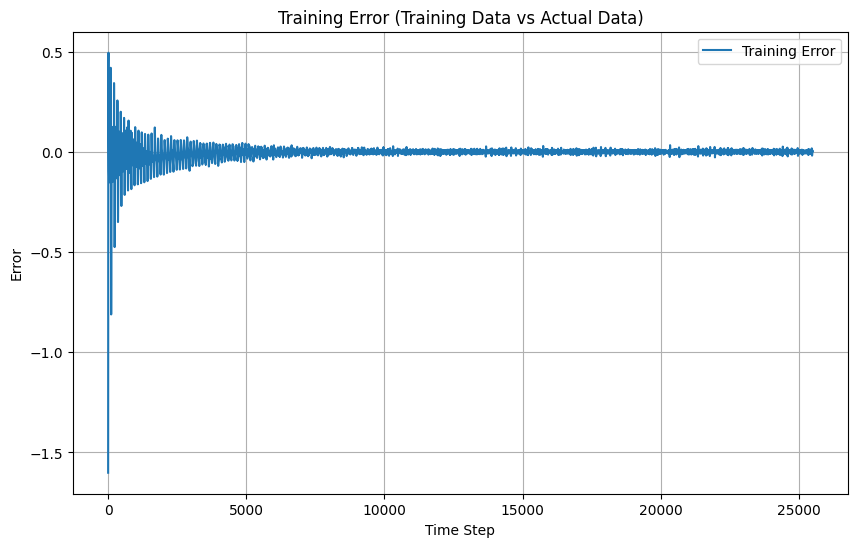

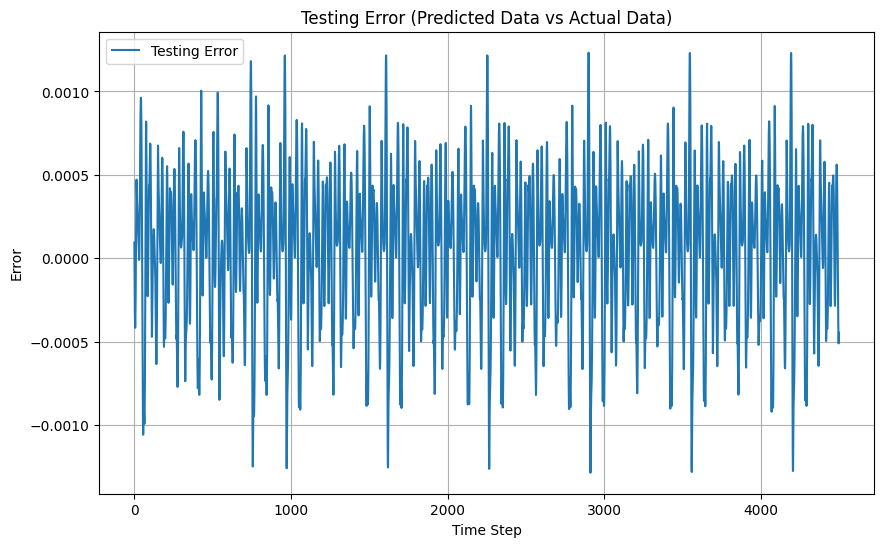

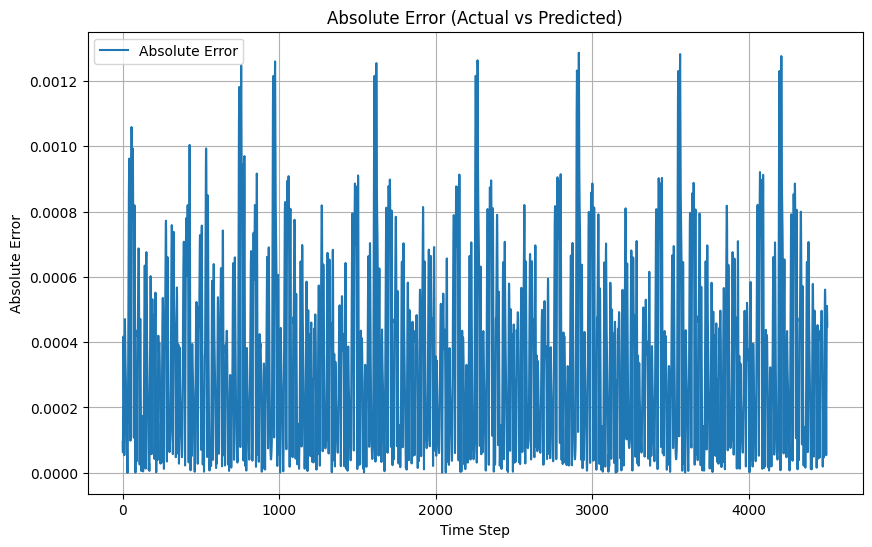

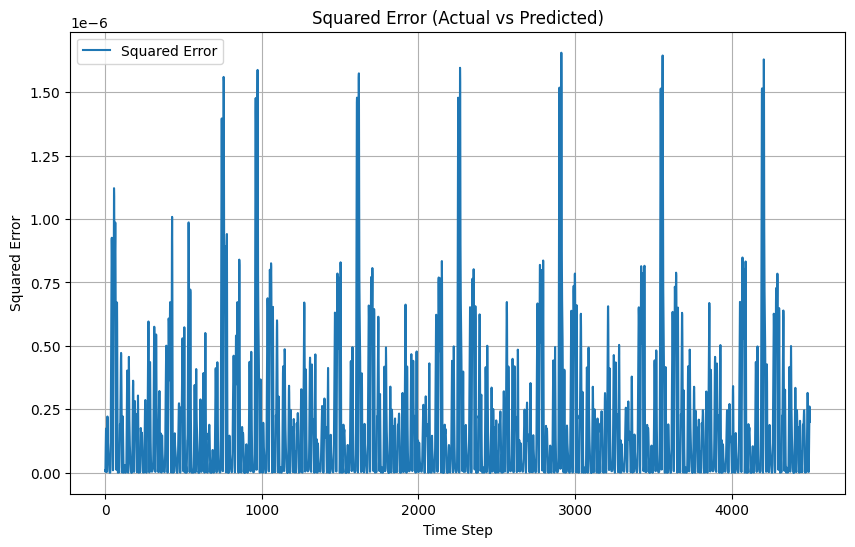

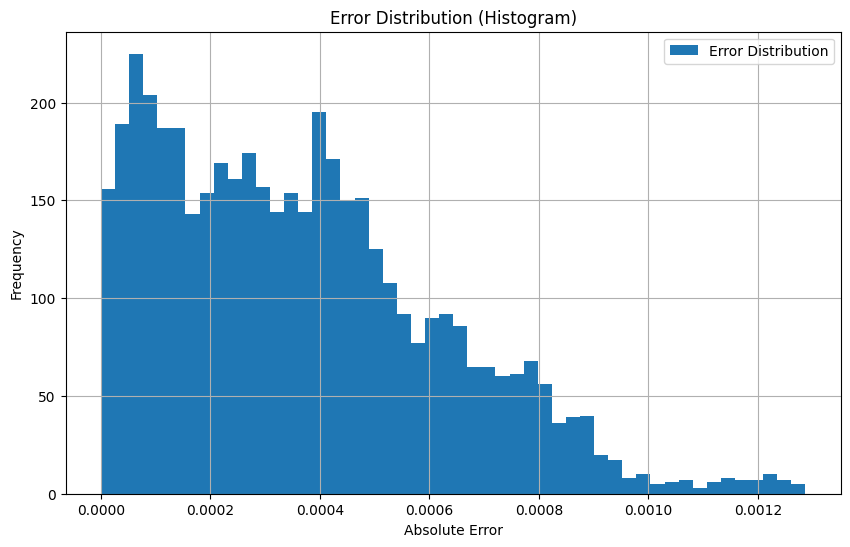

In [ ]:
import matplotlib.pyplot as plt

# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Calculate Training Error (difference between training predictions and actual training data)
Y_train_pred = model.predict(X_train).flatten()
training_error = Y_train_pred - Y_train.flatten()

# Plot Training Error (Training Data vs Actual Data)
plt.figure(figsize=(10, 6))
plt.plot(training_error, label='Training Error')
plt.title('Training Error (Training Data vs Actual Data)')
plt.xlabel('Time Step')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()

# Calculate Testing Error (difference between predicted data and actual testing data)
testing_error = Y_pred - Y_test.flatten()

# Plot Testing Error (Predicted Data vs Actual Data)
plt.figure(figsize=(10, 6))
plt.plot(testing_error, label='Testing Error')
plt.title('Testing Error (Predicted Data vs Actual Data)')
plt.xlabel('Time Step')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()

# Plot Absolute Error (Actual vs Predicted)
abs_error = np.abs(Y_pred - Y_test.flatten())

plt.figure(figsize=(10, 6))
plt.plot(abs_error, label='Absolute Error')
plt.title('Absolute Error (Actual vs Predicted)')
plt.xlabel('Time Step')
plt.ylabel('Absolute Error')
plt.legend()
plt.grid(True)
plt.show()

# Plot Squared Error (Actual vs Predicted)
squared_error = (Y_pred - Y_test.flatten()) ** 2

plt.figure(figsize=(10, 6))
plt.plot(squared_error, label='Squared Error')
plt.title('Squared Error (Actual vs Predicted)')
plt.xlabel('Time Step')
plt.ylabel('Squared Error')
plt.legend()
plt.grid(True)
plt.show()

# Plot Error Distribution (Histogram)
plt.figure(figsize=(10, 6))
plt.hist(abs_error, bins=50, label='Error Distribution')
plt.title('Error Distribution (Histogram)')
plt.xlabel('Absolute Error')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()


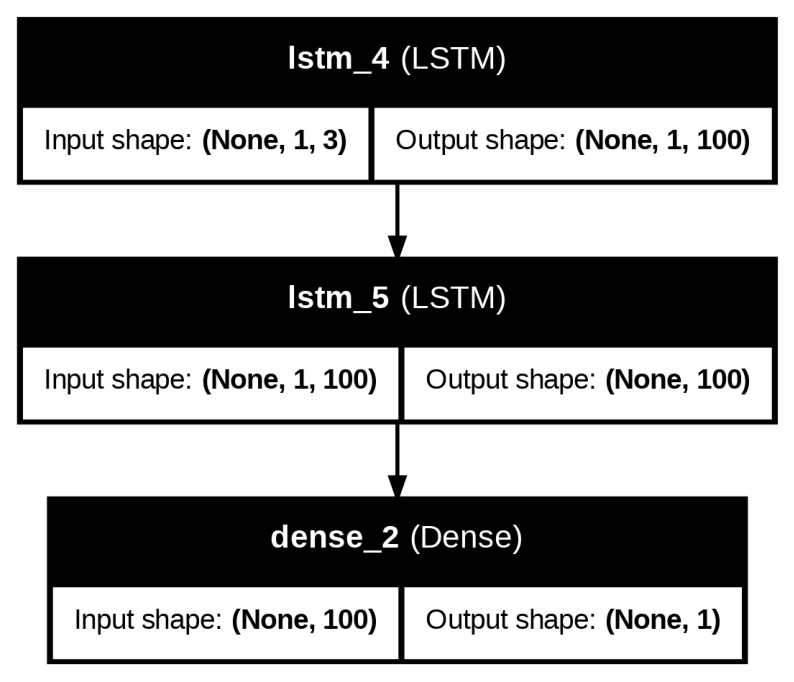

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 1, 100)              │          41,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 100)                 │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 366,305 (1.40 MB)

 Trainable params: 122,101 (476.96 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 244,204 (953.93 KB)

In [ ]:
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

# Plot the Network Architecture
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

# Display the architecture plot
img = plt.imread('model_architecture.png')
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

# Plot the summary of model layers
model.summary()
